In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from random import shuffle
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D,Dense,Flatten, AveragePooling2D, Dropout, Input, DepthwiseConv2D, SeparableConv2D
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [11]:
Map = {'1':0, '2':1, '5':2, '10':3, '20':4, '50':5, '100':6, '200':7, '500':8, '1000':9}
notes = [1, 2, 5, 10, 20, 50, 100,200, 500, 1000]
IMG_SIZE = 100
training_data = []
validation_data = []
testing_data = []

In [12]:
def create_train_data():
    DIR = "TK4/Training/"
    for tki in range(0,10):
        DIR2 = DIR + str(notes[tki])
        
        sl = 0;
        for img in tqdm(os.listdir(DIR2)):
            label = tki
            #print(label)
            path = os.path.join(DIR2, img)
            #img = cv2.imread(path)
            #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = Image.open(path)
            img = img.resize((IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), label])
            sl = sl+1
          #  if sl==612:
           #     break
            
  
    shuffle(training_data)

In [13]:
create_train_data()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:09<00:00, 93.59it/s]


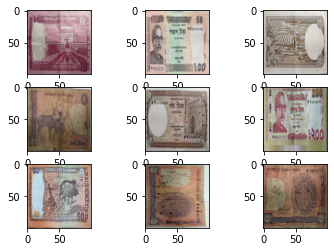

In [14]:
for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(training_data[i][0])
plt.show()

In [15]:
for i in range(9):
  print(notes[training_data[i][1]], end=' ')

10 50 5 1 5 200 50 1 1 

In [16]:
X = np.array([i[0] for i in training_data])
Y = np.array([i[1] for i in training_data])

X1, X2, Y1, Y2 = train_test_split(X, Y, test_size = 0.25, random_state=42, stratify=Y)
#X3, X4, Y3, Y4 = train_test_split(X2, Y2, test_size = 0.50, random_state=42, stratify=Y)

train_x = X1
train_y = Y1
val_x = X2
val_y = Y2
#test_x = X4
#test_y = Y4

print(Y1)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
#print(test_y.shape)


train_len = train_y.shape[0]
val_len = val_y.shape[0]
#test_len = test_y.shape[0]
print(train_len)

[3 2 1 ... 0 3 8]
(6750, 100, 100, 3)
(6750,)
(2250, 100, 100, 3)
(2250,)
6750


In [17]:
train_x = train_x.reshape(train_len, IMG_SIZE, IMG_SIZE, 3)
val_x = val_x.reshape(val_len, IMG_SIZE, IMG_SIZE, 3)
#test_x = test_x.reshape(test_len, IMG_SIZE, IMG_SIZE, 3)

train_x = train_x.astype('float32')
val_x = val_x.astype('float32')
#test_x = test_x.astype('float32')

train_x/=255
val_x/=255
#test_x/=255

In [18]:
print(train_y)
n_classes = 10
train_y = np_utils.to_categorical(train_y, n_classes)
val_y = np_utils.to_categorical(val_y, n_classes)
#test_y = np_utils.to_categorical(test_y, n_classes)

[3 2 1 ... 0 3 8]


In [19]:
baseModel = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

baseModel.summary()

87916544/87910968 [==============================] - 388s 4us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 49, 49, 32)   96          conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 49, 49, 32)   0           batch_normalization_71[0][0]     
____________________

In [20]:
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.regularizers import l1
headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
#headModel2 = Conv2D(32, kernel_size=(2,2), strides=(1,1), padding="valid", activation="relu")(headModel2)
#headModel2 = MaxPool2D(pool_size=(2,2))(headModel2)

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu", activity_regularizer=l1(0.0001))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.2)(headModel)

headModel = Dense(512, activation="relu", activity_regularizer=l1(0.0001))(headModel)
headModel = BatchNormalization()(headModel)

headModel = Dense(n_classes, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

#model.summary()
print(type(model))

<class 'tensorflow.python.keras.engine.functional.Functional'>


In [21]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
his2 = model.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(val_x, val_y))

Epoch 1/10
211/211 [==============================] - 110s 485ms/step - loss: 0.5963 - accuracy: 0.8445 - val_loss: 0.2595 - val_accuracy: 0.9422
Epoch 2/10
211/211 [==============================] - 92s 439ms/step - loss: 0.1560 - accuracy: 0.9690 - val_loss: 0.2798 - val_accuracy: 0.9329
Epoch 3/10
211/211 [==============================] - 91s 432ms/step - loss: 0.1421 - accuracy: 0.9758 - val_loss: 0.1307 - val_accuracy: 0.9778
Epoch 4/10
211/211 [==============================] - 91s 432ms/step - loss: 0.1053 - accuracy: 0.9818 - val_loss: 0.1485 - val_accuracy: 0.9689
Epoch 5/10
211/211 [==============================] - 91s 433ms/step - loss: 0.1050 - accuracy: 0.9775 - val_loss: 0.2296 - val_accuracy: 0.9449
Epoch 6/10
211/211 [==============================] - 91s 433ms/step - loss: 0.1044 - accuracy: 0.9788 - val_loss: 0.1243 - val_accuracy: 0.9760
Epoch 7/10
211/211 [==============================] - 92s 435ms/step - loss: 0.0757 - accuracy: 0.9881 - val_loss: 0.1189 - val_a

In [22]:
scores = model.evaluate(val_x, val_y)
print(scores[1]*100) 

71/71 [==============================] - 22s 310ms/step - loss: 0.3031 - accuracy: 0.9347
93.46666932106018


In [23]:
y_pred = model.predict(val_x)
y_pred=np.argmax(y_pred, axis=1)
val_y=np.argmax(val_y, axis=1)
print("f1 score : ", f1_score(val_y, y_pred, average="macro"))
print("precision score : ", precision_score(val_y, y_pred, average="macro"))
print("recall score : ", recall_score(val_y, y_pred, average="macro"))    

f1 score :  0.9351118165936226
precision score :  0.9438173665024786
recall score :  0.9346666666666665
